## Final Project Submission

Please fill out:
* Student name:  Thien Nguyen
* Student pace: **self paced** / part time / full time
* Scheduled project review date/time: 
* Instructor name: Eli Thomas
* Blog post URL:


# Module 3 Final Project: Classifiying Hand Gestures

### Background

Prosthetic limbs have helped numerous people resume their normal lives even after an accident. Prosthetics, such as an arm, can usually be controlled by cables linking elsewhere in the body (e.g. one arm can be used to control the other). However, this can be cumbersome and redundant. However, myoelectric prosthetics are more advanced because they can read the electric signals of existing, contracting muscles, which can then be used to control the prosthetic. 

Because individual users may have varying electric signals, it is crucial to collect user-specific data and create an effective model that can correctly interpret the intentions of the user. The following dataset on kaggle has been collected by Kirill Yashuk and shows readings from 8 sensors from a Myo armband designed to pick up electrical signals of muscle contractions. Each reading corresponds to one of four different hand postures:

0 - rock

1 - paper

2 - scissors

3 - 'ok'

This investigation will utilize a variety of supervised learning models to correctly classify each reading. A conclusion will be presented at the end to summarize results.

## Part 1. Gathering, Scrubbing, and Exploring Data

The data was sampled at 400 Hz, so each row represents 40ms of time. Collectively, there is about 2 minutes of recorded data for each hand posture. However, since each posture is saved in a separate file, combining everyting to one dataframe would be the best option

In [2]:
# Import necessary libraries

from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, svm
import xgboost as xgb
from sklearn.cluster import KMeans
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import timeit
%matplotlib inline

In [3]:
#read all csv
df0= pd.read_csv('0.csv')
df1= pd.read_csv('1.csv')
df2= pd.read_csv('2.csv')
df3= pd.read_csv('3.csv')

#Each of the dataframes have different column names, so let's ensure all the column names are the same

#for-loop to generate column names for the first 64 columns
column_names = []
for x in range(1,9):
    for y in range(1,9):
        column_names.append('m{}s{}'.format(x,y))

#add the target column
column_names.append('target')

df0.columns = column_names
df1.columns = column_names
df2.columns = column_names
df3.columns = column_names

#concatenate everything to one dataframe
df = pd.concat([df0, df1, df2, df3])

print(df.shape)
df.head()

(11674, 65)


,m1s1,m1s2,m1s3,m1s4,m1s5,m1s6,m1s7,m1s8,m2s1,m2s2,...,m7s8,m8s1,m8s2,m8s3,m8s4,m8s5,m8s6,m8s7,m8s8,target
0,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
1,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
2,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
3,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0
4,15.0,-5.0,-5.0,-15.0,12.0,-22.0,-38.0,36.0,9.0,6.0,...,-26.0,5.0,6.0,6.0,11.0,5.0,30.0,-48.0,25.0,0


The column names of the dataframe are strange and seem like it could be the first reading of data. However, since the kaggle documentation had no explanation, and there are already over 11000 entries of data, it would be fine to drop and replace the column names with something more appropriate:

m1s1 for muscle 1 sensor 1,
m1s2 for muscle 1 sensor 2,
and so on...


In [4]:
df.describe()

,m1s1,m1s2,m1s3,m1s4,m1s5,m1s6,m1s7,m1s8,m2s1,m2s2,...,m7s8,m8s1,m8s2,m8s3,m8s4,m8s5,m8s6,m8s7,m8s8,target
count,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,...,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000,11674.000000
mean,-0.520644,-0.728199,-0.738393,-0.729998,-0.159757,-0.552253,-1.262978,-0.654960,-0.665667,-0.652390,...,-0.931043,-0.839644,-0.740278,-0.768717,-0.705671,-0.148278,-0.378020,-1.443807,-0.609303,1.503255
std,18.567059,11.767147,4.989693,7.442282,17.852132,25.810290,25.074413,15.398179,18.126643,11.841696,...,15.158873,18.197682,12.007060,4.969706,7.385313,17.841925,25.553998,25.258353,15.531573,1.117541
min,-116.000000,-104.000000,-33.000000,-75.000000,-121.000000,-122.000000,-128.000000,-128.000000,-110.000000,-128.000000,...,-128.000000,-116.000000,-128.000000,-46.000000,-74.000000,-103.000000,-128.000000,-128.000000,-124.000000,0.000000
25%,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-15.000000,-6.000000,-8.000000,-9.000000,-4.000000,...,-8.000000,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-14.000000,-6.000000,-8.000000,1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,2.000000
75%,7.000000,3.000000,2.000000,3.000000,10.000000,13.000000,4.000000,6.000000,6.000000,3.000000,...,6.000000,6.000000,3.000000,2.000000,3.000000,10.000000,13.000000,3.000000,6.000000,3.000000
max,111.000000,90.000000,34.000000,55.000000,92.000000,127.000000,127.000000,126.000000,127.000000,106.000000,...,114.000000,127.000000,105.000000,29.000000,51.000000,110.000000,127.000000,127.000000,127.000000,3.000000


There are quite a few rows and over 60 columns of data. The last column is the corresponding hand sign. 

In [5]:
df.isna().any().sum()

0

The data appears pretty clean with no null values. Looking at the description, it doesn't appear like there are any placeholder null values either.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019CB176D828>,
      dtype=object)

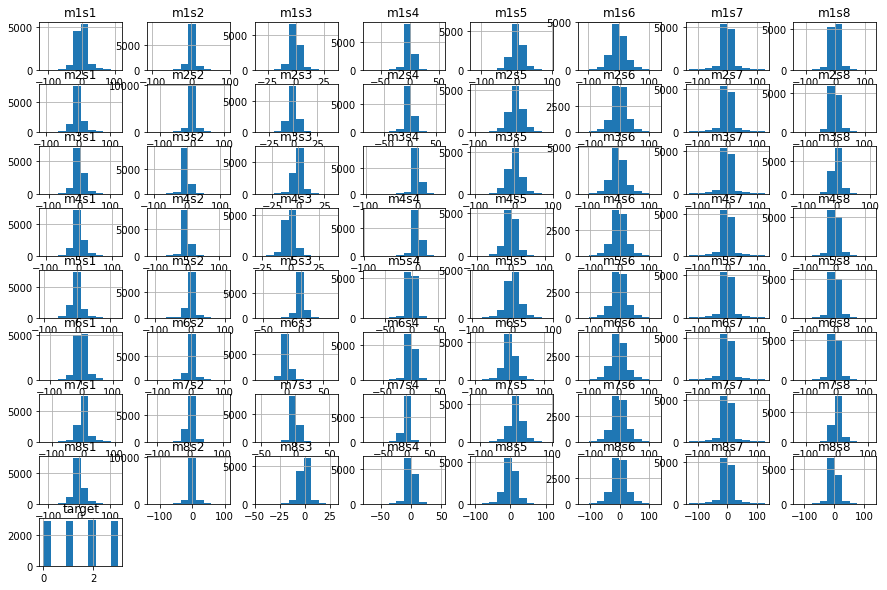

In [6]:
df.hist(figsize=(15,10))

Looking at the histograms, it seems most of the data is pretty normally distributed with some data being more kurtic than others. And even though the values do not vary widely, it would probably still be a good idea to scale the data later on.

In [7]:
#In addition, we might as well replace the numbers with the actually gesture category
df.target =df.target.replace([0,1,2,3],['rock', 'paper', 'scissors','ok'])
df.head()

,m1s1,m1s2,m1s3,m1s4,m1s5,m1s6,m1s7,m1s8,m2s1,m2s2,...,m7s8,m8s1,m8s2,m8s3,m8s4,m8s5,m8s6,m8s7,m8s8,target
0,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,rock
1,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,rock
2,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,rock
3,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,rock
4,15.0,-5.0,-5.0,-15.0,12.0,-22.0,-38.0,36.0,9.0,6.0,...,-26.0,5.0,6.0,6.0,11.0,5.0,30.0,-48.0,25.0,rock


# Part 2: Feature Selection with PCA

Since there are 64 features within the dataframe, principal component analysis will be used to scale down on the number of features to reduce dimensionality. For now, let's see what would be an optimal number of features to keep.

In [8]:
#Split into feature and target set

X = df[df.columns[:-1]]
y = df.target

#Scale the features
X = StandardScaler().fit_transform(X)
pd.DataFrame(data = X, columns = column_names[:-1]).head()


,m1s1,m1s2,m1s3,m1s4,m1s5,m1s6,m1s7,m1s8,m2s1,m2s2,...,m7s7,m7s8,m8s1,m8s2,m8s3,m8s4,m8s5,m8s6,m8s7,m8s8
0,-2.503431,-0.448029,-0.854119,-0.842520,0.737185,-0.017348,1.446276,-0.606919,0.588422,-0.282709,...,-4.086753,-1.587848,2.628999,0.561384,1.362054,0.772603,0.736963,0.836618,4.451938,1.005048
1,-0.995319,-0.618001,-1.455384,-0.976893,-1.167431,-0.211078,-3.100386,0.821883,0.036725,0.477350,...,-4.996018,-5.414154,0.430823,0.644671,0.355915,-0.987723,0.400662,0.836618,4.570716,3.129843
2,0.135765,0.316845,0.147990,0.366838,0.008949,0.873807,4.277969,-0.866701,-0.845992,-0.113807,...,-2.070558,-2.445468,-0.558356,0.394808,1.563281,1.585061,1.857966,1.541039,4.768679,2.807904
3,0.351209,0.061887,0.147990,-0.170654,-0.775304,0.408857,-1.983662,0.367264,0.422913,0.055095,...,2.436232,2.568312,-1.877262,-0.604647,0.557143,0.908013,-0.720341,-0.924434,-4.377203,-4.403522
4,0.835959,-0.363043,-0.854119,-1.917505,0.681167,-0.831012,-1.465183,2.380576,0.533253,0.561801,...,0.933969,-1.653819,0.320914,0.561384,1.362054,1.585061,0.288562,1.188828,-1.843279,1.648925


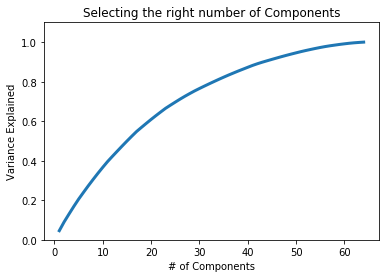

In [9]:
#Run PCA on the scaled features
pca = PCA()
pca.fit(X)

#plot a cumulative plot of explain variance to threshold
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.arange(len(cumsum))+1

plt.plot(dim,cumsum,'-',lw=3);

plt.xlabel('# of Components')
plt.ylabel('Variance Explained')
plt.title('Selecting the right number of Components')

plt.ylim([0,1.1]);

The graph seems to start leveling off around 40-45 components. Let's see which number is the optimal value

In [10]:
#List of possible variance thresholds
variance_thresholds = [.8, .85, .9, .95]

#prints the minimum number of principal components needed for each threshold
for threshold in variance_thresholds:
    pca = PCA (n_components = threshold)
    pca.fit_transform(X)
    print('{} Principal components are needed to explain {}% of the data'.format(pca.n_components_,threshold*100))

33 Principal components are needed to explain 80.0% of the data
38 Principal components are needed to explain 85.0% of the data
44 Principal components are needed to explain 90.0% of the data
51 Principal components are needed to explain 95.0% of the data


It seems like 44 components will allow our model to still explain 90% of the data's original variance, so that will be how many components our PCA will include

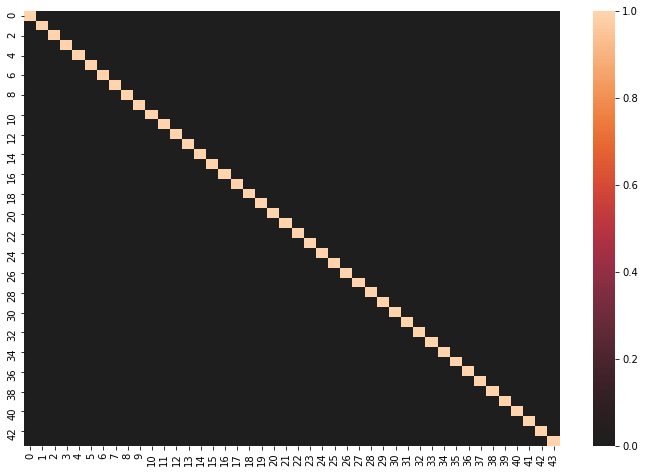

In [11]:
#Run PCA with 41 components
pca = PCA(n_components = 44)
X_pca = pca.fit_transform(X)

#plot a heatmap with the selected components
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(X_pca).corr(), center = 0)

The heatmap shows no hint of any multicollinearity between any of the features. This means that we can proceed to creating a model.

## Part 3: Modeling and Interpreting Data

For this section, the data will be modeled using the following modeling approaches:

- Naive Bayes
- Decision Tree
- Random Forest
- Support Vector Machine
- XGboost

Each model will be run via Pipeline with default parameters and then evaluated based on accuracy scores. Afterwards, gridsearch and Bayes optimization will be used in conjunction with Pipeline to find the optimal parameters for each model.

In [12]:
#perform and 80/20 split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 69)

In [13]:
#Create pipelines for each of the modeling approaches
NB_pipe = Pipeline([('pca', PCA(n_components =44)), ('clf', GaussianNB())])
tree_pipe = Pipeline([('pca', PCA(n_components =44)), ('clf', tree.DecisionTreeClassifier(random_state = 69))])
forest_pipe = Pipeline([('pca', PCA(n_components =44)), ('clf', RandomForestClassifier(random_state = 69))])
svm_pipe = Pipeline([('pca', PCA(n_components =44)), ('clf', svm.SVC(random_state = 69))])
xg_pipe = Pipeline([('pca', PCA(n_components =44)), ('clf', xgb.XGBClassifier(random_state = 69))])

#Create a list to iterate through
pipelines = [NB_pipe, tree_pipe, forest_pipe, svm_pipe, xg_pipe]
pipe_names = ['Naive_Bayes', 'Tree', 'Random_Forest', 'SVM', 'XGBoost']

#Use a for-loop to fit each pipeline to the training data
for pipe in pipelines:
    pipe.fit(X_train, y_train)

#print out the value score for each pipeline
for i,v in enumerate(pipelines):
    print('{} pipeline test accuracy: {}'.format(pipe_names[i], v.score(X_test, y_test)))

C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Naive_Bayes pipeline test accuracy: 0.5550321199143469
Tree pipeline test accuracy: 0.5224839400428265
Random_Forest pipeline test accuracy: 0.6616702355460385
SVM pipeline test accuracy: 0.8946466809421841
XGBoost pipeline test accuracy: 0.684796573875803


In [ ]:
print('Testing Score', svm_pipe.score(X_test, y_test)*100)
print('Training Score', svm_pipe.score(X_train, y_train)*100)

### Analysis
Every method performed significantly better than chance (25%). The Random Forest, SVM, and XGBoost model delivered the highest accuracy, which is unsurprising considering that they are more advanced than the Naive Bayes and Decision Tree model. However, the Support Vector Machine model did significantly better than all other models. Moving forward, GridSearch and Bayes Optimization will be employed to find the optimal parametrs for only the models with the 3 highest accuracy scores--Random Forest, SVM, and XGBoost.

## 3a. Random Forest with grid search & Bayes Optimization

In [30]:
grid_forest_param = [
    {'clf__n_estimators':[40, 100,250],
    'clf__criterion': ['gini'],
    'clf__max_depth': [5,6],
    'clf__min_samples_leaf': [10, 15],
    'clf__min_samples_split': [2,5]}
]
#create grid search
forest_grid = GridSearchCV(estimator = forest_pipe,
                          param_grid = grid_forest_param,
                          scoring = 'accuracy',
                          cv=3, verbose = 1, return_train_score = True)
#fit with grid search
forest_grid.fit(X_train, y_train)

#prints best accuracy and corresponding parameters
print('Best accuracy {}%'.format(forest_grid.best_score_*100))
print('Best parameters:{}'.format(forest_grid.best_params_))

forest_grid_training_score = np.mean(forest_grid.cv_results_['mean_train_score'])
forest_grid_testing_score = forest_grid.score(X, y)

print("Mean Training Score: {:.4}%".format(forest_grid_training_score * 100))
print("Mean Testing Score: {:.4}%".format(forest_grid_testing_score * 100))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  2.4min finished


Best accuracy 62.96177320912303%
Best parameters:{'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 250}
Mean Training Score: 66.14%
Mean Testing Score: 66.83%


In [31]:
#set grid search parameters
opt_forest_param = {
    'clf': Categorical([RandomForestClassifier(random_state = 69)]),
    'clf__n_estimators':Integer(1,200),
    'clf__criterion': Categorical(['gini']),
    'clf__max_depth': Integer(5,10),
    'clf__min_samples_leaf': Integer(10,15),
    'clf__min_samples_split': Integer(2,10)}


forest_opt = BayesSearchCV(
    forest_pipe, [(opt_forest_param, 50)], cv = 3
)

forest_opt.fit(X_train, y_train)

print('Best score:', forest_opt.best_score_*100)
print('\n')
print('Best Parameters:', forest_opt.best_params_)
print('\n')
print('Test Score:', forest_opt.score(X_test, y_test))
print('Train Score:', forest_opt.score(X_train, y_train))


C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective h

Best score: 68.81893136310097


Best Parameters: {'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=69, verbose=0, warm_start=False), 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}


Test Score: 0.6826552462526767
Train Score: 0.7829532069814755


### Random Forest Analysis

Neither methods were able to find parameters that did significantly better than the default Random Forest parameters (66% accuracy). Bayes Optimization fared somewhat better than Grid Search, but somewhat overfitted the training data. 

## 3b. XGBoost with grid search & Bayes Optimization

In [17]:
#set grid search parameters
grid_xgb_param = {
    "clf__learning_rate": [0.1, .3],
    'clf__max_depth': [6],
    'clf__min_child_weight': [1,10],
    'clf__subsample': [0.7],
    'clf__n_estimators': [30, 100, 250]
}

#create grid search
xgb_grid = GridSearchCV(estimator = xg_pipe,
                          param_grid = grid_xgb_param,
                          scoring = 'accuracy',
                          cv=3, verbose = 1, return_train_score = True)

#fit with grid search
xgb_grid.fit(X_train, y_train)

#prints best accuracy and corresponding parameters
print('Best accuracy {}%'.format(xgb_grid.best_score_*100))
print('Best parameters:{}'.format(xgb_grid.best_params_))

xgb_grid_training_score = np.mean(xgb_grid.cv_results_['mean_train_score'])
xgb_grid_testing_score = xgb_grid.score(X, y)

print("Mean Training Score: {:.4}%".format(xgb_grid_training_score * 100))
print("Mean Testing Score: {:.4}%".format(xgb_grid_testing_score * 100))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.8min finished


Best accuracy 0.8518042616982546%
Best parameters:{'clf__learning_rate': 0.3, 'clf__max_depth': 6, 'clf__min_child_weight': 1, 'clf__n_estimators': 250, 'clf__subsample': 0.7}
Mean Training Score: 95.86%
Mean Testing Score: 97.49%


In [32]:
#set grid search parameters
opt_xgb_param = {
    'clf': Categorical([xgb.XGBClassifier(random_state = 69)]),
    'clf__learning_rate':Real(.01, 1),
    'clf__n_estimators': Integer(10,300),
    'clf__max_depth': Integer(4,6),
    'clf__min_child_weight': Integer(1,5),
    'clf__subsample': Real(.01,1)
    }


xgb_opt = BayesSearchCV(
    xg_pipe, [(opt_xgb_param, 50)], cv = 3
)

xgb_opt.fit(X_train, y_train)

print('Best Score:', xgb_opt.best_score_)
print('Best Parameters', xgb_opt.best_params_)
print('\n')
print('Testing Score', xgb_opt.score(X_test, y_test))
print('Training Score', xgb_opt.score(X_train, y_train))

Best Score: 0.8525538066174109
Best Parameters {'clf': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3743797994793451,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=69, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7345842370842154), 'clf__learning_rate': 0.3743797994793451, 'clf__max_depth': 6, 'clf__min_child_weight': 1, 'clf__n_estimators': 300, 'clf__subsample': 0.7345842370842154}


Testing Score 0.8758029978586723
Training Score 1.0


### XGBoost Analysis
The accuracy and parameters between both Grid Search and Bayes Optimization are very similar. Both were able to achieve a relatively high accuracy score, especially when compared to default parameters (68%). Overall, there is about a 17% boost in accuracy when using either method to tune the hyperparameters of XGBoost. The main distinction is that the model created with Bayes Optimization clearly overfitted the data. This may be due to the higher learning rate and n-estimators of the Bayes model.

## 3. SVM with grid search & Bayes Optimization

#### SVM with Grid Search

In [21]:
#set grid search parameters
grid_svm_param = [
    {'clf__kernel':['rbf'],
    'clf__C': [.1,1,10],
    'clf__gamma': [.1, 1,10]
    },
    {'clf__kernel':['poly'],
    'clf__coef0': [1,10],
    'clf__gamma': [.1,1,10],
    'clf__degree': [3,8]
    },
    {'clf__kernel':['sigmoid'],
    'clf__coef0': [1,10],
    'clf__gamma': [.1,1,10]
    }
]


#create grid search
svm_grid = GridSearchCV(estimator = svm_pipe,
                          param_grid = grid_svm_param,
                          scoring = 'accuracy',
                          cv=3, verbose = 1, return_train_score = True)
#fit with grid search
svm_grid.fit(X_train, y_train)

svm_grid_training_score = np.mean(svm_grid.cv_results_['mean_train_score'])
svm_grid_testing_score = svm_grid.score(X, y)

#Prints train and test data scores to check for overfitting
print("Mean Training Score: {:.4}%".format(svm_grid_training_score * 100))
print("Mean Testing Score: {:.4}%".format(svm_grid_testing_score * 100))

#prints best accuracy and corresponding parameters
print('Best accuracy {}%'.format(svm_grid.best_score_))
print('Best parameters:{}'.format(svm_grid.best_params_))

print("Mean Training Score: {:.4}%".format(svm_grid_training_score * 100))
print("Mean Testing Score: {:.4}%".format(svm_grid_testing_score * 100))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  9.4min finished


Mean Training Score: 71.75%
Mean Testing Score: 97.74%
Best accuracy 0.8600492558089732%
Best parameters:{'clf__coef0': 10, 'clf__degree': 3, 'clf__gamma': 0.1, 'clf__kernel': 'poly'}
Mean Training Score: 71.75%
Mean Testing Score: 97.74%


#### Bayes Optimization with RBF Kernel

In [27]:
#set grid search parameters
opt_svm_rbf_param = {
    'clf__kernel':['rbf'],
    'clf__C': Integer(1,10),
    'clf__gamma': 'Real'(.001,10, 'log-uniform')
    }


svm_rbf_opt = BayesSearchCV(
    svm_pipe, [(opt_svm_rbf_param, 30)], cv = 3
)

svm_rbf_opt.fit(X_train, y_train)

print('Best Score:', svm_rbf_opt.best_score_*100)
print('Best Parameters', svm_rbf_opt.best_params_)

print('Testing Score', svm_rbf_opt.score(X_test, y_test)*100)
print('Training Score', svm_rbf_opt.score(X_train, y_train)*100)

Best Score: 0.8939929328621908
Best Parameters {'clf__C': 8, 'clf__gamma': 0.016620584576073228, 'clf__kernel': 'rbf'}
Testing Score 0.9049250535331905
Training Score 0.9842595566977193


#### Bayes Optimization with polynomial kernel

In [28]:
#set grid search parameters
opt_svm_poly_param ={
    'clf__kernel':['poly'],
    'clf__coef0': Real(1, 3),
    'clf__gamma': Real(.001,10,'log-uniform'),
    'clf__degree': Integer(3,8)
    }


svm_poly_opt = BayesSearchCV(
    svm_pipe, [(opt_svm_poly_param, 30)], cv = 3
)

svm_poly_opt.fit(X_train, y_train)

print('Best Score:', svm_poly_opt.best_score_*100)
print('Best Parameters', svm_poly_opt.best_params_)
print('\n')
print('Testing Score', svm_poly_opt.score(X_test, y_test)*100)
print('Training Score', svm_poly_opt.score(X_train, y_train)*100)

Best Score: 0.8893885855016597
Best Parameters {'clf__coef0': 2.7225212735118736, 'clf__degree': 7, 'clf__gamma': 0.001, 'clf__kernel': 'poly'}


Testing Score 0.9019271948608137
Training Score 0.9749437841310633


#### Bayes Optimization with Sigmoid kernel

In [29]:
#set grid search parameters
opt_svm_sig_param = {
    'clf__kernel':['sigmoid'],
    'clf__coef0': Real(.001,10, 'log-uniform'),
    'clf__gamma': Real(.001,10, 'log-uniform')
    }


svm_sig_opt = BayesSearchCV(
    svm_pipe, [(opt_svm_sig_param, 30)], cv = 3
)

svm_sig_opt.fit(X_train, y_train)

print('Best Score:', svm_sig_opt.best_score_*100)
print('Best Parameters', svm_sig_opt.best_params_)
print('\n')
print('Testing Score', svm_sig_opt.score(X_test, y_test)*100)
print('Training Score', svm_sig_opt.score(X_train, y_train)*100)

Best Score: 0.2920012849341471
Best Parameters {'clf__coef0': 0.003944774316410204, 'clf__gamma': 0.002567144803978056, 'clf__kernel': 'sigmoid'}


Testing Score 0.278372591006424
Training Score 0.31277438697933396


### SVM Analysis

The default SVM classification already had a very high accuracy rate (89.4%), so finding significant improvements on accuracy results are unlikely. Using Grid Search returned 'polynomial' as the best kernel for hyperparameter tuning. However, comparison of accuracy between rbf and polynomial revealed insignificant differences. In both cases, there is some overfitting on the training data, but not enough to be a concern. However, it is clear that a sigmoid kernel is a poor predictor for the data. 


## Data Interpretation

Overall, SVM with either 'rbf' or 'polynomial' kernel performed the best in classifying hand gestures based on electric impulses. The modicum of difference of accuracy between the two methods are not enough to rule either as superior to the other. In addition, XGBoost had a significant increase in accuracy after hyperparameter optimization with both Bayes Optimization and Grid Search. This suggests that XGBoost has potential to surpass both SVM kernels in accurately predicting hand gestures. 


## Future Considerations

This investigation is mainly limited by time. Testing and tuning hyperparameters requires multiple iterations, which leads to hundreds of models being created and tested based on the training data. Even two approaches for hyperparamter optimization--Grid Search and Bayes Optimization-- takes considerable time, as results from one method can be used to fine tune the other all while being careful not to overfit the data. 

This is somewhat tedious as other hyperparameter optimization methods, like gradient-based optimization and evolutionary optimization, may produce better hyperparameters in less time. In addition, it would be beneficial to test other more advanced classification methods such as MLP (Multi-layer Perceptron) and LSTM (long short-term memory) to see if higher accuracy can be obtained. The only downside would be that these methods are more computationally expensive, and thus, cost more time as well.

# Project Summary:

### Obtain
1. Data sourced from kaggle by user Kirill Yashuk on electric impulses from a myo armband to predict hand gestures

### Scrub
2. CSV files for each hand position merged into one dataframe.
3. Exploration revealed no null values leading to a dataframe with 11674 rows and 64 features.

### Explore
4. Features scaled with Standard Scaler. 
5. Principal Component Analysis used to reduced feature count to 44 while maintaing 90% variance.
6. Heatmap indicates no multicollinearity between features and data split 80/20.

### Model
7. Five models with default parameters created with Pipeline and evaluated on accuracy
    1. Naive_Bayes pipeline test accuracy: 55.50%
    2. Tree pipeline test accuracy: 52.25%
    3. Random_Forest pipeline test accuracy: 66.17%
    4. SVM pipeline test accuracy: 89.46%
    5. XGBoost pipeline test accuracy: 68.48%
    
8. Random Forest, SVM, and XGBoost classifier repeated in conjunction with Bayes Optimization and Grid Search for hyperparameter optimization
    1. Random Forest
        1. Grid Search Accuracy - 62.96%
        2. Bayes Accuracy - 68.82%
    2. XGBoost
        1. Grid Search Accuracy - 85.18%
        2. Bayes Accuracy - 85.26%
    3. SVM 
        1. Grid Search Accuracy - 86.00%
        2. Bayes Accuracy (rbf) - 89.40%
        3. Bayes Accuracy (polynomial) - 88.94%
        
### Interpret
9. Support Vector Machine with base parameters achieved the highest accuracy, although not by much. However, it would still be the best model due to lack of overfitting, as exhibited with the Bayes Optimization of both the rbf and polynomial kernels.

### Future Considerations
10. With additional time and computational resources, MLP and LSTM classification via neural networks may provide better accuracy. In addition, hyperparamter optimization can be improved with gradient-based and evolutionary optimization.